In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys
import time
import glob
import logging
import torch
import numpy as np
from tqdm import tqdm
from thop import profile
from random import shuffle
import torch.nn as nn
import torch.utils
import torchvision
from torch.utils.tensorboard import SummaryWriter
from config_search import config
from dataloader import get_train_loader, get_valid_loader
from tools.datasets import Cityscapes
from architect_lbt import Architect
from model_search import Network_Multi_Path as Network
from student import Student_Network
from model_seg import Network_Multi_Path_Infer
from utils.darts_utils import create_exp_dir, save, plot_op, plot_path_width, objective_acc_lat
from utils.init_func import init_weight
from eval import SegEvaluator
from matplotlib import pyplot as plt

/home/zetang/ECE269_final_project/model/tools/utils/darts_utils.py:179: UserWarning: TensorRT (or pycuda) is not installed. compute_latency_ms_tensorrt() cannot be used.
  warnings.warn("TensorRT (or pycuda) is not installed. compute_latency_ms_tensorrt() cannot be used.")


In [2]:
config.save = 'search-lbt-{}-{}'.format(config.save, time.strftime("%Y%m%d-%H%M%S"))
create_exp_dir(config.save, scripts_to_save=glob.glob('*.py')+glob.glob('*.sh'))
logger = SummaryWriter(os.path.join(config.save, 'runs'))

log_format = '%(asctime)s %(message)s'
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format=log_format, datefmt='%m/%d %I:%M:%S %p')
fh = logging.FileHandler(os.path.join(config.save, 'log.txt'))
fh.setFormatter(logging.Formatter(log_format))
logging.getLogger().addHandler(fh)

logging.info("args = %s", str(config))

# preparation ################
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
seed = config.seed
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
model = Network(config.num_classes, config.layers, Fch=config.Fch, width_mult_list=config.width_mult_list, prun_modes=['max'], stem_head_width=config.stem_head_width)
#init_weight(model, nn.init.kaiming_normal_, nn.BatchNorm2d, config.bn_eps, config.bn_momentum, mode='fan_in', nonlinearity='relu')
partial = torch.load('search-lbt-224x448_F12.L5_batch2-20210320-185706' + "/weights.pt", map_location='cuda:0')
state = model.state_dict()
pretrained_dict = {k: v for k, v in partial.items() if k in state and state[k].size() == partial[k].size()}
state.update(pretrained_dict)
model.load_state_dict(state)
model = model.cuda()
#student = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False, progress=True, num_classes=config.num_classes, aux_loss=None)
student = Student_Network()
partial = torch.load('search-lbt-224x448_F12.L5_batch2-20210320-185706' + "/weights_s.pt", map_location='cuda:0')
state = student.state_dict()
pretrained_dict = {k: v for k, v in partial.items() if k in state and state[k].size() == partial[k].size()}
state.update(pretrained_dict)
student.load_state_dict(state)
student = student.cuda()

Experiment dir : search-lbt-224x448_F12.L5_batch2-20210322-133914


22 13:39:16 args = {'seed': 12345, 'repo_name': 'ECE269_final_project', 'abs_dir': '/home/zetang/ECE269_final_project/model', 'this_dir': 'model', 'root_dir': '/home/zetang/ECE269_final_project', 'dataset_path': '/datasets/cityscapes/', 'img_root_folder': '/datasets/cityscapes/', 'gt_root_folder': '/datasets/cityscapes/', 'train_source': 'tools/datasets/cityscapes/cityscapes_train_fine.txt', 'eval_source': 'tools/datasets/cityscapes/cityscapes_val_fine.txt', 'test_source': 'tools/datasets/cityscapes/cityscapes_test.txt', 'num_classes': 35, 'background': -1, 'image_mean': array([0.485, 0.456, 0.406]), 'image_std': array([0.229, 0.224, 0.225]), 'down_sampling': 2, 'image_height': 224, 'image_width': 448, 'gt_down_sampling': 8, 'num_train_imgs': 2975, 'num_eval_imgs': 500, 'bn_eps': 1e-05, 'bn_momentum': 0.1, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0005, 'num_workers': 4, 'train_scale_array': [0.75, 1, 1.25], 'eval_stride_rate': 0.8333333333333334, 'eval_scale_array': [1], 'eval_fl

In [3]:
architect = Architect(model, student)

data_setting = {'img_root': config.img_root_folder,
                    'gt_root': config.gt_root_folder,
                    'train_source': config.train_source,
                    'eval_source': config.eval_source,
                    'down_sampling': config.down_sampling}
index_select = list(range(config.num_train_imgs))
shuffle(index_select)  # shuffle to make sure balanced dataset split
train_loader_model = get_train_loader(config, Cityscapes, portion=config.train_portion, index_select=index_select)
train_loader_arch = get_train_loader(config, Cityscapes, portion=config.train_portion-1, index_select=index_select)
evaluator = SegEvaluator(Cityscapes(data_setting, 'val', None), config.num_classes, config.image_mean,
                             config.image_std, model, config.eval_scale_array, config.eval_flip, 0, config=config,
                             verbose=False, save_path=None, show_image=False)
valid_loader = get_valid_loader(config, Cityscapes)

using downsampling: 2
Found 1487 images
using downsampling: 2
Found 1488 images
using downsampling: 2
Found 500 images
using downsampling: 2
Found 500 images


In [4]:
base_lr = config.lr
parameters = []
parameters += list(model.stem.parameters())
parameters += list(model.cells.parameters())
parameters += list(model.refine32.parameters())
parameters += list(model.refine16.parameters())
parameters += list(model.head0.parameters())
parameters += list(model.head1.parameters())
parameters += list(model.head2.parameters())
parameters += list(model.head02.parameters())
parameters += list(model.head12.parameters())
optimizer = torch.optim.SGD(
    parameters,
    lr=base_lr,
    momentum=config.momentum,
    weight_decay=config.weight_decay)
optimizer_stud = torch.optim.SGD(student.parameters(),lr=base_lr,
    momentum=config.momentum,
    weight_decay=config.weight_decay)
# lr policy ##############################
lr_policy = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.978)
lr_policy_stud = torch.optim.lr_scheduler.ExponentialLR(optimizer_stud, 0.978)


In [5]:
def cusloss(inp, tar):
    m = nn.Softmax(1)
    lm = nn.LogSoftmax(1)
    lenn = inp.shape[0]
    inp = lm(inp)
    tar = m(tar)
    out = inp*tar
    ll = (out.sum()*(-1))/lenn
    return ll
def train(train_loader_model, train_loader_arch, valid_loader, model, student, architect, optimizer, optimizer_stud, base_lr, logger, epoch, update_arch=True):
    model.train()
    student.train()

    bar_format = '{desc}[{elapsed}<{remaining},{rate_fmt}]'
    pbar = tqdm(range(config.niters_per_epoch), file=sys.stdout, bar_format=bar_format, ncols=80)
    dataloader_model = iter(train_loader_model)
    dataloader_arch = iter(train_loader_arch)
    dataloader_valid = iter(valid_loader)

    for step in pbar:
        minibatch = dataloader_model.next()
        imgs = minibatch['data']
        imgs = imgs.cuda(non_blocking=True)
        labels = minibatch['label']
        labels = labels.cuda(non_blocking=True)
        minibatch_val = dataloader_arch.next()
        imgs_val = minibatch_val['data']
        imgs_val = imgs_val.cuda(non_blocking=True)
        labels_val = minibatch_val['label']
        labels_val = labels_val.cuda(non_blocking=True)
        minibatch_unlabeled = dataloader_valid.next()
        imgs_unlabeled = minibatch_unlabeled['data']
        imgs_unlabeled = imgs_unlabeled.cuda(non_blocking=True)
        imgs_unlabeled = imgs_unlabeled.to(dtype=torch.float)

        # get a random minibatch from the search queue with replacement
        pbar.set_description("[Arch Step %d/%d]" % (step + 1, len(train_loader_model)))
        architect.step(imgs, labels, imgs_val, labels_val, imgs_unlabeled, base_lr, optimizer, unrolled=True)
        architect.step1(imgs, labels, imgs_val, labels_val, imgs_unlabeled, base_lr, optimizer, optimizer_stud, unrolled=True)
        optimizer.zero_grad()
        loss = model._loss(imgs, labels)
        nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
        loss.backward()
        optimizer.step()

        optimizer_stud.zero_grad()
        logits1 = student(imgs_unlabeled)
        logits2 = model(imgs_unlabeled)
        pred = torch.zeros_like(logits2[0])
        for l in logits2:
            pred = pred + l
        logits2 = pred / 5
        loss = cusloss(logits1, logits2)
        loss.backward()
        optimizer_stud.step()

        optimizer_stud.zero_grad()
        loss = student._loss(imgs, labels)
        loss.backward()
        optimizer_stud.step()
        pbar.set_description("[Step %d/%d]" % (step + 1, len(train_loader_model)))
    torch.cuda.empty_cache()
        
        
def infer(epoch, model, evaluator, logger, FPS=True):
    model.eval()
    mIoUs = []
    for idx in range(5):
        evaluator.out_idx = idx
        # _, mIoU = evaluator.run_online()
        _, mIoU = evaluator.run_online_multiprocess()
        mIoUs.append(mIoU)
    if FPS:
        fps0, fps1 = arch_logging(model, config, logger, epoch)
        return mIoUs, fps0, fps1
    else:
        return mIoUs


def arch_logging(model, args, logger, epoch):
    input_size = (1, 3, 1024, 2048)
    net = Network_Multi_Path_Infer(
        [getattr(model, model._arch_names[model.arch_idx]["alphas"][0]).clone().detach(), getattr(model, model._arch_names[model.arch_idx]["alphas"][1]).clone().detach(), getattr(model, model._arch_names[model.arch_idx]["alphas"][2]).clone().detach()],
        [None, getattr(model, model._arch_names[model.arch_idx]["betas"][0]).clone().detach(), getattr(model, model._arch_names[model.arch_idx]["betas"][1]).clone().detach()],
        [getattr(model, model._arch_names[model.arch_idx]["ratios"][0]).clone().detach(), getattr(model, model._arch_names[model.arch_idx]["ratios"][1]).clone().detach(), getattr(model, model._arch_names[model.arch_idx]["ratios"][2]).clone().detach()],
        num_classes=model._num_classes, layers=model._layers, Fch=model._Fch, width_mult_list=model._width_mult_list, stem_head_width=model._stem_head_width[model.arch_idx])

    plot_op(net.ops0, net.path0, F_base=args.Fch).savefig("table.png", bbox_inches="tight")
    logger.add_image("arch/ops0_arch%d"%model.arch_idx, np.swapaxes(np.swapaxes(plt.imread("table.png"), 0, 2), 1, 2), epoch)
    plot_op(net.ops1, net.path1, F_base=args.Fch).savefig("table.png", bbox_inches="tight")
    logger.add_image("arch/ops1_arch%d"%model.arch_idx, np.swapaxes(np.swapaxes(plt.imread("table.png"), 0, 2), 1, 2), epoch)
    plot_op(net.ops2, net.path2, F_base=args.Fch).savefig("table.png", bbox_inches="tight")
    logger.add_image("arch/ops2_arch%d"%model.arch_idx, np.swapaxes(np.swapaxes(plt.imread("table.png"), 0, 2), 1, 2), epoch)

    net.build_structure([2, 0])
    net = net.cuda()
    net.eval()
    latency0, _ = net.forward_latency(input_size[1:])
    logger.add_scalar("arch/fps0_arch%d"%model.arch_idx, 1000./latency0, epoch)
    logger.add_figure("arch/path_width_arch%d_02"%model.arch_idx, plot_path_width([2, 0], [net.path2, net.path0], [net.widths2, net.widths0]), epoch)

    net.build_structure([2, 1])
    net = net.cuda()
    net.eval()
    latency1, _ = net.forward_latency(input_size[1:])
    logger.add_scalar("arch/fps1_arch%d"%model.arch_idx, 1000./latency1, epoch)
    logger.add_figure("arch/path_width_arch%d_12"%model.arch_idx, plot_path_width([2, 1], [net.path2, net.path1], [net.widths2, net.widths1]), epoch)

    return 1000./latency0, 1000./latency1
        

In [6]:
tbar = tqdm(range(config.nepochs), ncols=80)
valid_mIoU_history = []; FPSs_history = [];
latency_supernet_history = []; latency_weight_history = [];
valid_names = ["8s", "16s", "32s", "8s_32s", "16s_32s"]
arch_names = {0: "teacher"}
for epoch in tbar:
    logging.info(config.save)
    logging.info("lr: " + str(optimizer.param_groups[0]['lr']))

    # training
    tbar.set_description("[Epoch %d/%d][train...]" % (epoch + 1, config.nepochs))
    train(train_loader_model, train_loader_arch, valid_loader, model, student, architect, optimizer, optimizer_stud, base_lr, logger, epoch, update_arch=True)
    torch.cuda.empty_cache()
    lr_policy.step()
    lr_policy_stud.step()

    # validation
    tbar.set_description("[Epoch %d/%d][validation...]" % (epoch + 1, config.nepochs))
    with torch.no_grad():
        valid_mIoUss = []; FPSs = []
        model.prun_mode = None
        for idx in range(len(model._arch_names)):
            # arch_idx
            model.arch_idx = idx
            valid_mIoUs, fps0, fps1 = infer(epoch, model, evaluator, logger)
            valid_mIoUss.append(valid_mIoUs)
            FPSs.append([fps0, fps1])
            for i in range(5):
                # preds
                logger.add_scalar('mIoU/val_%s_%s'%(arch_names[idx], valid_names[i]), valid_mIoUs[i], epoch)
                logging.info("Epoch %d: valid_mIoU_%s_%s %.3f"%(epoch, arch_names[idx], valid_names[i], valid_mIoUs[i]))
        valid_mIoU_history.append(valid_mIoUss)
        FPSs_history.append(FPSs)

    save(model, os.path.join(config.save, 'weights.pt'))

  0%|                                                    | 0/30 [00:00<?, ?it/s]22 13:39:24 search-lbt-224x448_F12.L5_batch2-20210322-133914
22 13:39:24 lr: 0.01
[Epoch 1/30][train...]:   0%|                            | 0/30 [00:00<?, ?it/s]


[00:00<?,?it/s]
[Arch Step 1/743]: [00:01<?,?it/s]

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of sub is deprecated:
	sub(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	sub(Tensor other, *, Number alpha)



[Step 1/743]: [00:24<?,?it/s]     
[Step 1/743]: [00:24<5:06:32,24.79s/it]
[Arch Step 2/743]: [00:24<5:06:32,24.79s/it]
[Step 2/743]: [00:43<5:06:32,24.79s/it]     
[Step 2/743]: [00:43<4:43:28,22.95s/it]
[Arch Step 3/743]: [00:43<4:43:28,22.95s/it]
[Step 3/743]: [01:02<4:43:28,22.95s/it]     
[Step 3/743]: [01:02<4:28:13,21.75s/it]
[Arch Step 4/743]: [01:02<4:28:13,21.75s/it]
[Step 4/743]: [01:21<4:28:13,21.75s/it]     
[Step 4/743]: [01:21<4:19:35,21.08s/it]
[Arch Step 5/743]: [01:21<4:19:35,21.08s/it]
[Step 5/743]: [01:39<4:19:35,21.08s/it]     
[Step 5/743]: [01:39<4:07:08,20.09s/it]
[Arch Step 6/743]: [01:39<4:07:08,20.09s/it]
[Step 6/743]: [01:58<4:07:08,20.09s/it]     
[Step 6/743]: [01:58<4:01:28,19.66s/it]
[Arch Step 7/743]: [01:58<4:01:28,19.66s/it]
[Step 7/743]: [02:16<4:01:28,19.66s/it]     
[Step 7/743]: [02:16<3:56:29,19.28s/it]
[Arch Step 8/743]: [02:16<3:56:29,19.28s/it]
[Step 8/743]: [02:35<3:56:29,19.28s/it]     
[Step 8/743]: [02:35<3:53:16,19.04s/it]
[Arch Step 9/7

[Arch Step 59/743]: [17:20<3:23:47,17.85s/it]
[Step 59/743]: [17:37<3:23:47,17.85s/it]     
[Step 59/743]: [17:37<3:23:21,17.84s/it]
[Arch Step 60/743]: [17:37<3:23:21,17.84s/it]
[Step 60/743]: [17:56<3:23:21,17.84s/it]     
[Step 60/743]: [17:56<3:26:17,18.12s/it]
[Arch Step 61/743]: [17:56<3:26:17,18.12s/it]
[Step 61/743]: [18:14<3:26:17,18.12s/it]     
[Step 61/743]: [18:14<3:24:08,17.96s/it]
[Arch Step 62/743]: [18:14<3:24:08,17.96s/it]
[Step 62/743]: [18:31<3:24:08,17.96s/it]     
[Step 62/743]: [18:31<3:22:41,17.86s/it]
[Arch Step 63/743]: [18:31<3:22:41,17.86s/it]
[Step 63/743]: [18:49<3:22:41,17.86s/it]     
[Step 63/743]: [18:49<3:21:42,17.80s/it]
[Arch Step 64/743]: [18:49<3:21:42,17.80s/it]
[Step 64/743]: [19:07<3:21:42,17.80s/it]     
[Step 64/743]: [19:07<3:20:47,17.74s/it]
[Arch Step 65/743]: [19:07<3:20:47,17.74s/it]
[Step 65/743]: [19:24<3:20:47,17.74s/it]     
[Step 65/743]: [19:24<3:20:35,17.75s/it]
[Arch Step 66/743]: [19:24<3:20:35,17.75s/it]
[Step 66/743]: [19:42<3

[Step 116/743]: [34:51<3:08:26,18.00s/it]     
[Step 116/743]: [34:51<3:08:40,18.06s/it]
[Arch Step 117/743]: [34:51<3:08:40,18.06s/it]
[Step 117/743]: [35:09<3:08:40,18.06s/it]     
[Step 117/743]: [35:09<3:07:51,18.01s/it]
[Arch Step 118/743]: [35:09<3:07:51,18.01s/it]
[Step 118/743]: [35:27<3:07:51,18.01s/it]     
[Step 118/743]: [35:27<3:07:53,18.04s/it]
[Arch Step 119/743]: [35:27<3:07:53,18.04s/it]
[Step 119/743]: [35:45<3:07:53,18.04s/it]     
[Step 119/743]: [35:45<3:08:19,18.11s/it]
[Arch Step 120/743]: [35:45<3:08:19,18.11s/it]
[Step 120/743]: [36:04<3:08:19,18.11s/it]     
[Step 120/743]: [36:04<3:11:17,18.42s/it]
[Arch Step 121/743]: [36:04<3:11:17,18.42s/it]
[Step 121/743]: [36:23<3:11:17,18.42s/it]     
[Step 121/743]: [36:23<3:12:25,18.56s/it]
[Arch Step 122/743]: [36:23<3:12:25,18.56s/it]
[Step 122/743]: [36:41<3:12:25,18.56s/it]     
[Step 122/743]: [36:41<3:10:00,18.36s/it]
[Arch Step 123/743]: [36:41<3:10:00,18.36s/it]
[Step 123/743]: [36:59<3:10:00,18.36s/it]     
[

[Step 172/743]: [51:41<2:42:56,17.12s/it]
[Arch Step 173/743]: [51:41<2:42:56,17.12s/it]
[Step 173/743]: [51:58<2:42:56,17.12s/it]     
[Step 173/743]: [51:58<2:44:07,17.28s/it]
[Arch Step 174/743]: [51:58<2:44:07,17.28s/it]
[Step 174/743]: [52:16<2:44:07,17.28s/it]     
[Step 174/743]: [52:16<2:45:17,17.43s/it]
[Arch Step 175/743]: [52:16<2:45:17,17.43s/it]
[Step 175/743]: [52:35<2:45:17,17.43s/it]     
[Step 175/743]: [52:35<2:49:05,17.86s/it]
[Arch Step 176/743]: [52:35<2:49:05,17.86s/it]
[Step 176/743]: [52:53<2:49:05,17.86s/it]     
[Step 176/743]: [52:53<2:48:42,17.85s/it]
[Arch Step 177/743]: [52:53<2:48:42,17.85s/it]
[Step 177/743]: [53:11<2:48:42,17.85s/it]     
[Step 177/743]: [53:11<2:48:28,17.86s/it]
[Arch Step 178/743]: [53:11<2:48:28,17.86s/it]
[Step 178/743]: [53:30<2:48:28,17.86s/it]     
[Step 178/743]: [53:30<2:52:12,18.29s/it]
[Arch Step 179/743]: [53:30<2:52:12,18.29s/it]
[Step 179/743]: [53:48<2:52:12,18.29s/it]     
[Step 179/743]: [53:48<2:51:40,18.26s/it]
[Arch 

[Arch Step 228/743]: [1:08:01<2:34:43,17.99s/it]
[Step 228/743]: [1:08:19<2:34:43,17.99s/it]     
[Step 228/743]: [1:08:19<2:34:42,18.02s/it]
[Arch Step 229/743]: [1:08:19<2:34:42,18.02s/it]
[Step 229/743]: [1:08:37<2:34:42,18.02s/it]     
[Step 229/743]: [1:08:37<2:33:56,17.97s/it]
[Arch Step 230/743]: [1:08:37<2:33:56,17.97s/it]
[Step 230/743]: [1:08:55<2:33:56,17.97s/it]     
[Step 230/743]: [1:08:55<2:33:22,17.94s/it]
[Arch Step 231/743]: [1:08:55<2:33:22,17.94s/it]
[Step 231/743]: [1:09:13<2:33:22,17.94s/it]     
[Step 231/743]: [1:09:13<2:33:50,18.03s/it]
[Arch Step 232/743]: [1:09:13<2:33:50,18.03s/it]
[Step 232/743]: [1:09:30<2:33:50,18.03s/it]     
[Step 232/743]: [1:09:30<2:31:41,17.81s/it]
[Arch Step 233/743]: [1:09:30<2:31:41,17.81s/it]
[Step 233/743]: [1:09:48<2:31:41,17.81s/it]     
[Step 233/743]: [1:09:48<2:31:31,17.83s/it]
[Arch Step 234/743]: [1:09:48<2:31:31,17.83s/it]
[Step 234/743]: [1:10:06<2:31:31,17.83s/it]     
[Step 234/743]: [1:10:06<2:32:02,17.92s/it]
[Arch 

[Arch Step 282/743]: [1:24:13<2:20:28,18.24s/it]
[Step 282/743]: [1:24:31<2:20:28,18.24s/it]     
[Step 282/743]: [1:24:31<2:19:06,18.10s/it]
[Arch Step 283/743]: [1:24:31<2:19:06,18.10s/it]
[Step 283/743]: [1:24:49<2:19:06,18.10s/it]     
[Step 283/743]: [1:24:49<2:18:00,18.00s/it]
[Arch Step 284/743]: [1:24:49<2:18:00,18.00s/it]
[Step 284/743]: [1:25:06<2:18:00,18.00s/it]     
[Step 284/743]: [1:25:06<2:16:59,17.91s/it]
[Arch Step 285/743]: [1:25:06<2:16:59,17.91s/it]
[Step 285/743]: [1:25:24<2:16:59,17.91s/it]     
[Step 285/743]: [1:25:24<2:16:46,17.92s/it]
[Arch Step 286/743]: [1:25:24<2:16:46,17.92s/it]
[Step 286/743]: [1:25:42<2:16:46,17.92s/it]     
[Step 286/743]: [1:25:42<2:16:10,17.88s/it]
[Arch Step 287/743]: [1:25:42<2:16:10,17.88s/it]
[Step 287/743]: [1:26:01<2:16:10,17.88s/it]     
[Step 287/743]: [1:26:01<2:16:55,18.02s/it]
[Arch Step 288/743]: [1:26:01<2:16:55,18.02s/it]
[Step 288/743]: [1:26:18<2:16:55,18.02s/it]     
[Step 288/743]: [1:26:18<2:16:14,17.97s/it]
[Arch 

[Arch Step 336/743]: [1:40:25<2:01:41,17.90s/it]
[Step 336/743]: [1:40:43<2:01:41,17.90s/it]     
[Step 336/743]: [1:40:43<2:01:10,17.86s/it]
[Arch Step 337/743]: [1:40:43<2:01:10,17.86s/it]
[Step 337/743]: [1:41:01<2:01:10,17.86s/it]     
[Step 337/743]: [1:41:01<2:01:03,17.89s/it]
[Arch Step 338/743]: [1:41:01<2:01:03,17.89s/it]
[Step 338/743]: [1:41:19<2:01:03,17.89s/it]     
[Step 338/743]: [1:41:19<2:01:07,17.94s/it]
[Arch Step 339/743]: [1:41:19<2:01:07,17.94s/it]
[Step 339/743]: [1:41:37<2:01:07,17.94s/it]     
[Step 339/743]: [1:41:37<2:01:11,18.00s/it]
[Arch Step 340/743]: [1:41:37<2:01:11,18.00s/it]
[Step 340/743]: [1:41:55<2:01:11,18.00s/it]     
[Step 340/743]: [1:41:55<2:00:53,18.00s/it]
[Arch Step 341/743]: [1:41:55<2:00:53,18.00s/it]
[Step 341/743]: [1:42:13<2:00:53,18.00s/it]     
[Step 341/743]: [1:42:13<2:00:27,17.98s/it]
[Arch Step 342/743]: [1:42:13<2:00:27,17.98s/it]
[Step 342/743]: [1:42:31<2:00:27,17.98s/it]     
[Step 342/743]: [1:42:31<2:00:16,18.00s/it]
[Arch 

[Arch Step 390/743]: [1:56:44<1:46:16,18.01s/it]
[Step 390/743]: [1:57:03<1:46:16,18.01s/it]     
[Step 390/743]: [1:57:03<1:46:45,18.15s/it]
[Arch Step 391/743]: [1:57:03<1:46:45,18.15s/it]
[Step 391/743]: [1:57:21<1:46:45,18.15s/it]     
[Step 391/743]: [1:57:21<1:46:09,18.10s/it]
[Arch Step 392/743]: [1:57:21<1:46:09,18.10s/it]
[Step 392/743]: [1:57:39<1:46:09,18.10s/it]     
[Step 392/743]: [1:57:39<1:45:17,18.00s/it]
[Arch Step 393/743]: [1:57:39<1:45:17,18.00s/it]
[Step 393/743]: [1:57:56<1:45:17,18.00s/it]     
[Step 393/743]: [1:57:56<1:44:54,17.98s/it]
[Arch Step 394/743]: [1:57:56<1:44:54,17.98s/it]
[Step 394/743]: [1:58:14<1:44:54,17.98s/it]     
[Step 394/743]: [1:58:14<1:44:01,17.89s/it]
[Arch Step 395/743]: [1:58:14<1:44:01,17.89s/it]
[Step 395/743]: [1:58:32<1:44:01,17.89s/it]     
[Step 395/743]: [1:58:32<1:43:29,17.84s/it]
[Arch Step 396/743]: [1:58:32<1:43:29,17.84s/it]
[Step 396/743]: [1:58:50<1:43:29,17.84s/it]     
[Step 396/743]: [1:58:50<1:43:28,17.89s/it]
[Arch 

[Arch Step 444/743]: [2:12:58<1:32:31,18.51s/it]
[Step 444/743]: [2:13:17<1:32:31,18.51s/it]     
[Step 444/743]: [2:13:17<1:33:19,18.73s/it]
[Arch Step 445/743]: [2:13:17<1:33:19,18.73s/it]
[Step 445/743]: [2:13:36<1:33:19,18.73s/it]     
[Step 445/743]: [2:13:36<1:33:35,18.84s/it]
[Arch Step 446/743]: [2:13:36<1:33:35,18.84s/it]
[Step 446/743]: [2:13:55<1:33:35,18.84s/it]     
[Step 446/743]: [2:13:55<1:33:32,18.90s/it]
[Arch Step 447/743]: [2:13:55<1:33:32,18.90s/it]
[Step 447/743]: [2:14:14<1:33:32,18.90s/it]     
[Step 447/743]: [2:14:14<1:33:22,18.93s/it]
[Arch Step 448/743]: [2:14:14<1:33:22,18.93s/it]
[Step 448/743]: [2:14:33<1:33:22,18.93s/it]     
[Step 448/743]: [2:14:33<1:33:42,19.06s/it]
[Arch Step 449/743]: [2:14:33<1:33:42,19.06s/it]
[Step 449/743]: [2:14:52<1:33:42,19.06s/it]     
[Step 449/743]: [2:14:52<1:33:20,19.05s/it]
[Arch Step 450/743]: [2:14:52<1:33:20,19.05s/it]
[Step 450/743]: [2:15:11<1:33:20,19.05s/it]     
[Step 450/743]: [2:15:11<1:32:07,18.87s/it]
[Arch 

[Arch Step 498/743]: [2:29:31<1:16:50,18.74s/it]
[Step 498/743]: [2:29:50<1:16:50,18.74s/it]     
[Step 498/743]: [2:29:50<1:16:40,18.78s/it]
[Arch Step 499/743]: [2:29:50<1:16:40,18.78s/it]
[Step 499/743]: [2:30:08<1:16:40,18.78s/it]     
[Step 499/743]: [2:30:08<1:16:24,18.79s/it]
[Arch Step 500/743]: [2:30:08<1:16:24,18.79s/it]
[Step 500/743]: [2:30:27<1:16:24,18.79s/it]     
[Step 500/743]: [2:30:27<1:15:48,18.72s/it]
[Arch Step 501/743]: [2:30:27<1:15:48,18.72s/it]
[Step 501/743]: [2:30:45<1:15:48,18.72s/it]     
[Step 501/743]: [2:30:45<1:14:16,18.42s/it]
[Arch Step 502/743]: [2:30:45<1:14:16,18.42s/it]
[Step 502/743]: [2:31:01<1:14:16,18.42s/it]     
[Step 502/743]: [2:31:01<1:12:08,17.96s/it]
[Arch Step 503/743]: [2:31:01<1:12:08,17.96s/it]
[Step 503/743]: [2:31:20<1:12:08,17.96s/it]     
[Step 503/743]: [2:31:20<1:12:27,18.11s/it]
[Arch Step 504/743]: [2:31:20<1:12:27,18.11s/it]
[Step 504/743]: [2:31:39<1:12:27,18.11s/it]     
[Step 504/743]: [2:31:39<1:13:08,18.36s/it]
[Arch 

[Step 552/743]: [2:46:15<57:25,17.95s/it]     
[Step 552/743]: [2:46:15<57:16,17.99s/it]
[Arch Step 553/743]: [2:46:15<57:16,17.99s/it]
[Step 553/743]: [2:46:33<57:16,17.99s/it]     
[Step 553/743]: [2:46:33<57:14,18.08s/it]
[Arch Step 554/743]: [2:46:33<57:14,18.08s/it]
[Step 554/743]: [2:46:52<57:14,18.08s/it]     
[Step 554/743]: [2:46:52<57:06,18.13s/it]
[Arch Step 555/743]: [2:46:52<57:06,18.13s/it]
[Step 555/743]: [2:47:10<57:06,18.13s/it]     
[Step 555/743]: [2:47:10<56:47,18.12s/it]
[Arch Step 556/743]: [2:47:10<56:47,18.12s/it]
[Step 556/743]: [2:47:28<56:47,18.12s/it]     
[Step 556/743]: [2:47:28<56:39,18.18s/it]
[Arch Step 557/743]: [2:47:28<56:39,18.18s/it]
[Step 557/743]: [2:47:46<56:39,18.18s/it]     
[Step 557/743]: [2:47:46<56:18,18.16s/it]
[Arch Step 558/743]: [2:47:46<56:18,18.16s/it]
[Step 558/743]: [2:48:04<56:18,18.16s/it]     
[Step 558/743]: [2:48:04<56:11,18.22s/it]
[Arch Step 559/743]: [2:48:05<56:11,18.22s/it]
[Step 559/743]: [2:48:22<56:11,18.22s/it]     
[

[Step 608/743]: [3:03:03<40:33,18.03s/it]
[Arch Step 609/743]: [3:03:03<40:33,18.03s/it]
[Step 609/743]: [3:03:21<40:33,18.03s/it]     
[Step 609/743]: [3:03:21<40:11,17.99s/it]
[Arch Step 610/743]: [3:03:21<40:11,17.99s/it]
[Step 610/743]: [3:03:39<40:11,17.99s/it]     
[Step 610/743]: [3:03:39<39:53,18.00s/it]
[Arch Step 611/743]: [3:03:39<39:53,18.00s/it]
[Step 611/743]: [3:03:57<39:53,18.00s/it]     
[Step 611/743]: [3:03:57<39:37,18.01s/it]
[Arch Step 612/743]: [3:03:57<39:37,18.01s/it]
[Step 612/743]: [3:04:15<39:37,18.01s/it]     
[Step 612/743]: [3:04:15<39:15,17.98s/it]
[Arch Step 613/743]: [3:04:15<39:15,17.98s/it]
[Step 613/743]: [3:04:33<39:15,17.98s/it]     
[Step 613/743]: [3:04:33<38:53,17.95s/it]
[Arch Step 614/743]: [3:04:33<38:53,17.95s/it]
[Step 614/743]: [3:04:51<38:53,17.95s/it]     
[Step 614/743]: [3:04:51<38:38,17.98s/it]
[Arch Step 615/743]: [3:04:51<38:38,17.98s/it]
[Step 615/743]: [3:05:09<38:38,17.98s/it]     
[Step 615/743]: [3:05:09<38:21,17.98s/it]
[Arch 

[Arch Step 665/743]: [3:19:59<23:51,18.13s/it]
[Step 665/743]: [3:20:18<23:51,18.13s/it]     
[Step 665/743]: [3:20:18<23:41,18.22s/it]
[Arch Step 666/743]: [3:20:18<23:41,18.22s/it]
[Step 666/743]: [3:20:36<23:41,18.22s/it]     
[Step 666/743]: [3:20:36<23:10,18.06s/it]
[Arch Step 667/743]: [3:20:36<23:10,18.06s/it]
[Step 667/743]: [3:20:54<23:10,18.06s/it]     
[Step 667/743]: [3:20:54<22:50,18.03s/it]
[Arch Step 668/743]: [3:20:54<22:50,18.03s/it]
[Step 668/743]: [3:21:12<22:50,18.03s/it]     
[Step 668/743]: [3:21:12<22:31,18.02s/it]
[Arch Step 669/743]: [3:21:12<22:31,18.02s/it]
[Step 669/743]: [3:21:29<22:31,18.02s/it]     
[Step 669/743]: [3:21:29<22:08,17.95s/it]
[Arch Step 670/743]: [3:21:29<22:08,17.95s/it]
[Step 670/743]: [3:21:47<22:08,17.95s/it]     
[Step 670/743]: [3:21:47<21:47,17.92s/it]
[Arch Step 671/743]: [3:21:47<21:47,17.92s/it]
[Step 671/743]: [3:22:05<21:47,17.92s/it]     
[Step 671/743]: [3:22:05<21:28,17.90s/it]
[Arch Step 672/743]: [3:22:05<21:28,17.90s/it]
[

[Step 721/743]: [3:37:03<06:56,18.11s/it]     
[Step 721/743]: [3:37:03<06:43,18.36s/it]
[Arch Step 722/743]: [3:37:03<06:43,18.36s/it]
[Step 722/743]: [3:37:21<06:43,18.36s/it]     
[Step 722/743]: [3:37:21<06:23,18.28s/it]
[Arch Step 723/743]: [3:37:21<06:23,18.28s/it]
[Step 723/743]: [3:37:38<06:23,18.28s/it]     
[Step 723/743]: [3:37:38<06:02,18.13s/it]
[Arch Step 724/743]: [3:37:38<06:02,18.13s/it]
[Step 724/743]: [3:37:56<06:02,18.13s/it]     
[Step 724/743]: [3:37:56<05:42,18.02s/it]
[Arch Step 725/743]: [3:37:56<05:42,18.02s/it]
[Step 725/743]: [3:38:14<05:42,18.02s/it]     
[Step 725/743]: [3:38:14<05:22,17.93s/it]
[Arch Step 726/743]: [3:38:14<05:22,17.93s/it]
[Step 726/743]: [3:38:31<05:22,17.93s/it]     
[Step 726/743]: [3:38:31<05:02,17.79s/it]
[Arch Step 727/743]: [3:38:31<05:02,17.79s/it]
[Step 727/743]: [3:38:49<05:02,17.79s/it]     
[Step 727/743]: [3:38:49<04:43,17.70s/it]
[Arch Step 728/743]: [3:38:49<04:43,17.70s/it]
[Step 728/743]: [3:39:07<04:43,17.70s/it]     
[

[Epoch 1/30][validation...]:   0%|                     | 0/30 [3:43:53<?, ?it/s]22 17:23:18 Thread 0 handle 167 data.
22 17:23:18 Thread 1 handle 167 data.
22 17:23:18 Thread 2 handle 166 data.

 57%|█████▋    | 287/500 [00:41<00:33,  6.31it/s]


100%|██████████| 500/500 [01:22<00:00,  6.07it/s]
22 17:24:58 Thread 0 handle 167 data.
22 17:24:58 Thread 1 handle 167 data.
22 17:24:58 Thread 2 handle 166 data.

  9%|▉         | 47/500 [00:01<00:49,  9.10it/s]


 55%|█████▌    | 276/500 [00:38<00:36,  6.10it/s]


 99%|█████████▉| 494/500 [01:17<00:02,  2.61it/s]


100%|██████████| 500/500 [01:20<00:00,  6.22it/s]
22 17:26:36 Thread 0 handle 167 data.
22 17:26:36 Thread 1 handle 167 data.
22 17:26:36 Thread 2 handle 166 data.

 50%|████▉     | 249/500 [00:34<00:40,  6.27it/s]


 96%|█████████▌| 479/500 [01:14<00:04,  4.55it/s]


100%|██████████| 500/500 [01:21<00:00,  6.15it/s]
22 17:28:15 Thread 0 handle 167 data.
22 17:28:15 Thread 1 handle 167 data.
22 17:28:15 Thread 2 handle 166 data.

 48%|████▊     | 242/500 [00:33<00:57,  4.48it/s]


 94%|█████████▍| 471/500 [01:12<00:06,  4.67it/s]


100%|██████████| 500/500 [01:22<00:00,  6.09it/s]
22 17:29:55 Thread 0 handle 167 data.
22 17:29:55 Thread 1 handle 167 data.
22 17:29:55 Thread 2 handle 166 data.

 40%|████      | 202/500 [00:26<00:46,  6.43it/s]


 87%|████████▋ | 434/500 [01:05<00:10,  6.16it/s]


100%|██████████| 500/500 [01:21<00:00,  6.16it/s]


[0, 0]
2
[0, 1, 1, 1]
4
[0, 1, 1, 2]
6


/home/zetang/ECE269_final_project/model/tools/utils/darts_utils.py:326: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
22 17:31:36 Epoch 0: valid_mIoU_teacher_8s 0.000
22 17:31:36 Epoch 0: valid_mIoU_teacher_16s 0.000
22 17:31:36 Epoch 0: valid_mIoU_teacher_32s 0.000
22 17:31:36 Epoch 0: valid_mIoU_teacher_8s_32s 0.000
22 17:31:36 Epoch 0: valid_mIoU_teacher_16s_32s 0.000
[Epoch 1/30][validation...]:   3%|▏     | 1/30 [3:52:12<112:14:11, 13932.80s/it]22 17:31:37 search-lbt-224x448_F12.L5_batch2-20210322-133914
22 17:31:37 lr: 0.00978
[Epoch 2/30][train...]:   3%|▎          | 1/30 [3:52:12<112:14:11, 13932.80s/it]


[00:00<?,?it/s]
[Arch Step 1/743]: [00:09<?,?it/s]

[Epoch 2/30][train...]:   3%|▎          | 1/30 [3:52:21<112:18:37, 13941.97s/it]

KeyboardInterrupt: 

In [13]:
partial = torch.load('search-lbt-224x448_F12.L5_batch2-20210320-185706' + "/weights.pt", map_location='cuda:0')
state = model.state_dict()
pretrained_dict = {k: v for k, v in partial.items() if k in state and state[k].size() == partial[k].size()}
state.update(pretrained_dict)
model.load_state_dict(state)

<All keys matched successfully>

In [14]:
partial = torch.load('search-lbt-224x448_F12.L5_batch2-20210320-185706' + "/weights_s.pt", map_location='cuda:0')
state = student.state_dict()
pretrained_dict = {k: v for k, v in partial.items() if k in state and state[k].size() == partial[k].size()}
state.update(pretrained_dict)
student.load_state_dict(state)

<All keys matched successfully>

In [20]:
dset = Cityscapes(data_setting, 'val', None)

using downsampling: 2
Found 500 images


In [30]:
batch = iter(valid_loader).next()

In [127]:
imgs = batch['data']
target = batch['label']

In [117]:
imgs = imgs.cuda()
imgs = imgs.to(dtype=torch.float)


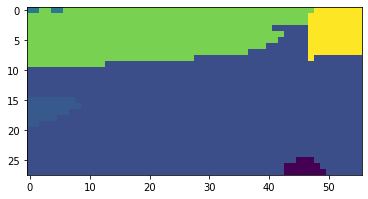

In [129]:
plt.imshow(target[1])
plt.show()

In [119]:
out_1 = model(imgs)

In [123]:
_, pred_1 = torch.max(out_1[4], 1)

In [124]:
pred_1 = pred_1.detach().cpu().numpy()

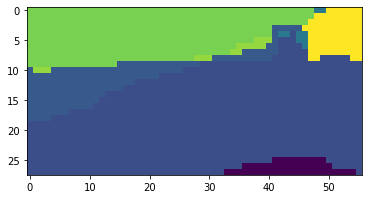

In [125]:
plt.imshow(pred_1[1])
plt.show()

In [115]:
batch = iter(train_loader_model).next()